In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

## define function for I(Q)

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

## evaluate probability density on 2D detector

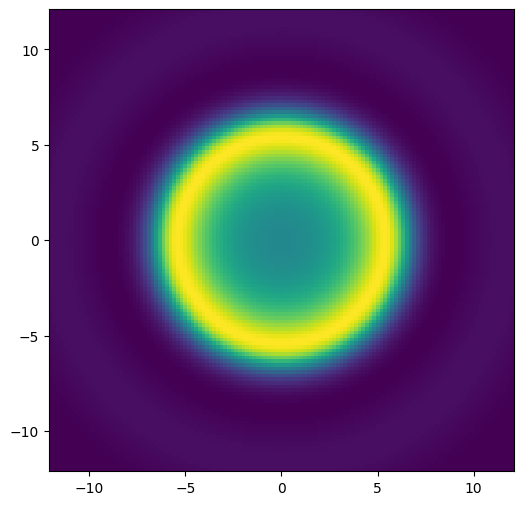

In [3]:
q_grid = np.linspace(-12, 12, 128)
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)

p_qxy = P_hs(q_rad)*S_hs(q_rad, 0.3)
p_qxy[np.isfinite(p_qxy)==0] = 0
p_qxy = p_qxy/np.sum(p_qxy)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, p_qxy, cmap='viridis')

## random sampling the scattering intensity

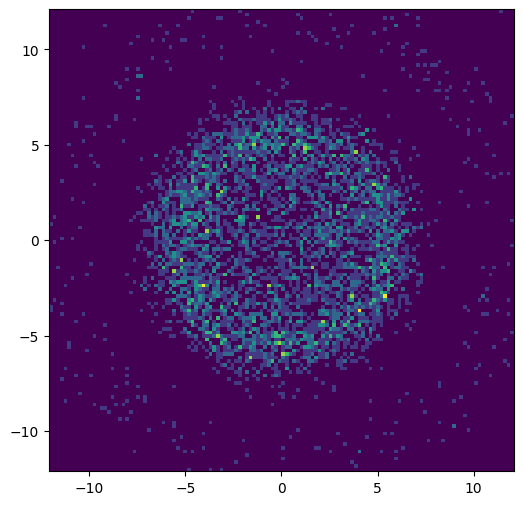

In [11]:
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]

n_sample = 5000  # specify the number of samples

n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

# Flatten the arrays
qx_flat = qx.flatten()
qy_flat = qy.flatten()
p_qxy_flat = p_qxy.flatten()

# Normalize the probability density
p_qxy_flat /= p_qxy_flat.sum()

# Randomly choose indices based on the probability density
indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

# Get the sampled qx and qy values
qx_samples = qx_flat[indices]
qy_samples = qy_flat[indices]

# evaluate the sampled point density in each grid

I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

# evaluate the radial averaged density
q = q_grid[q_grid > 0]
I_q = np.zeros_like(q)
I_q_th = np.zeros_like(q)
for i in range(len(q)):
    mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
    I_q[i] = I_q_grid[mask].mean()
    I_q_th[i] = p_qxy[mask].mean()

# Plot the sampled point density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.pcolormesh(qx, qy, I_q_grid.T, cmap='viridis')

# # Plot the radial averaged density
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# ax.plot(q, I_q, 'o')

# ax.plot(q, I_q_th*n_sample, '-')

In [5]:
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy):
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    I_q_th = np.zeros_like(q)
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_q[i] = I_q_grid[mask].mean()
        
    return I_q

## handle with noise by GPR

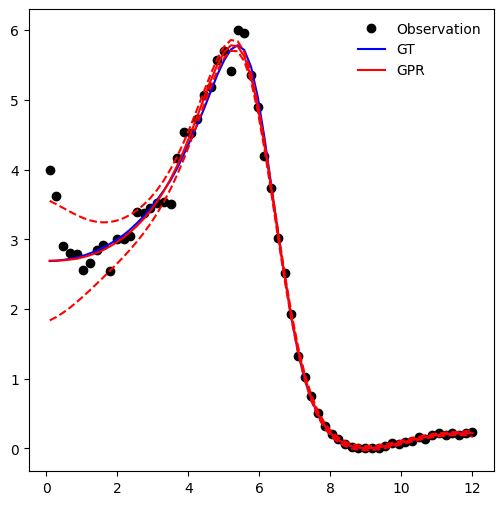

In [86]:
n_sample = 20000
I_q_grid = f_I_q(n_sample, p_qxy)
I_q = f_I_q_rad(I_q_grid, q)
I_q_th = f_I_q_rad(p_qxy*n_sample, q)
I_q_gf = gaussian_filter1d(I_q_th, 2)

# # Plot the radial averaged density
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# x_bg = 0
# ax.plot(q, I_q-I_q_gf*x_bg, 'ok')
# ax.plot(q, I_q_th-I_q_gf*x_bg, '-r')
# ax.plot(q, I_q_gf-I_q_gf*x_bg, '--k')

## define kernel function
y_gt = I_q_th-I_q_gf
y = I_q-I_q_gf
q_s = q

lmbda = 1
sigma = 0.5
def f_K_rbf(q1, q2, lmbda):
    K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)
    return K

sigma_rsq = np.diag((len(q)/(np.arange(len(q))+1))**2/10)
K_xx = f_K_rbf(q, q, lmbda) + sigma_rsq
# K_xx = f_K_rbf(q, q, lmbda) + sigma*np.eye(len(q))
K_xs = f_K_rbf(q, q_s, lmbda)
k_ss = f_K_rbf(q_s, q_s, lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q, y + I_q_gf, 'ok', label='Observation') 
ax.plot(q, y_gt + I_q_gf, '-b', label='GT')
ax.plot(q_s, mu_s + I_q_gf, '-r', label='GPR')
ax.plot(q_s, mu_s-var_s + I_q_gf, '--r')
ax.plot(q_s, mu_s+var_s + I_q_gf, '--r')

ax.legend(frameon=False)

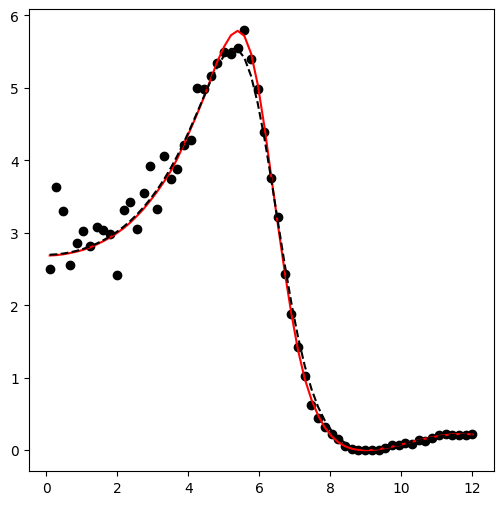

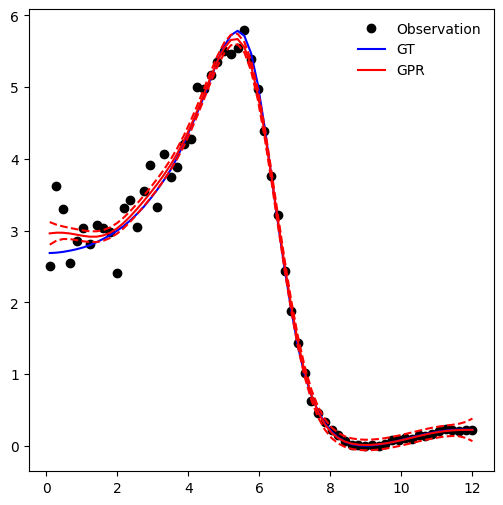

In [7]:
n_sample = 20000
I_q_grid = f_I_q(n_sample, p_qxy)
I_q = f_I_q_rad(I_q_grid, q)
I_q_th = f_I_q_rad(p_qxy*n_sample, q)
I_q_gf = gaussian_filter1d(I_q_th, 2)

# Plot the radial averaged density
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
x_bg = 0
ax.plot(q, I_q-I_q_gf*x_bg, 'ok')
ax.plot(q, I_q_th-I_q_gf*x_bg, '-r')
ax.plot(q, I_q_gf-I_q_gf*x_bg, '--k')

## define kernel function
y_gt = I_q_th-I_q_gf
y = I_q-I_q_gf
q_s = q

lmbda = 1
sigma = 0.5
def f_K_rbf(q1, q2, lmbda):
    K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)
    return K

K_xx = f_K_rbf(q, q, lmbda) + sigma*np.eye(len(q))
K_xs = f_K_rbf(q, q_s, lmbda)
k_ss = f_K_rbf(q_s, q_s, lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)

# plot the GPR result
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q, y + I_q_gf, 'ok', label='Observation') 
ax.plot(q, y_gt + I_q_gf, '-b', label='GT')
ax.plot(q_s, mu_s + I_q_gf, '-r', label='GPR')
ax.plot(q_s, mu_s-var_s + I_q_gf, '--r')
ax.plot(q_s, mu_s+var_s + I_q_gf, '--r')

ax.legend(frameon=False)